## Libraries

In [74]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os 

from sklearn.linear_model import LogisticRegression     # Regression Logistic
from sklearn.neighbors import KNeighborsClassifier      # K Near Neighbors
from sklearn.svm import SVC                             # Support Vector Machines
from sklearn.tree import DecisionTreeClassifier         # Decision tree
from sklearn.ensemble import BaggingClassifier          # Ensemble models: Bagging
from sklearn.ensemble import RandomForestClassifier     # Ensemble models: Random Forest
from sklearn.ensemble import StackingClassifier         # Ensemble models: Stacking
from sklearn.ensemble import GradientBoostingClassifier # Ensemble models: Gradient Boosting GB
from sklearn.ensemble import AdaBoostClassifier         # Ensemble models: GB AdaBoost

from xgboost import XGBClassifier                       # Ensemble models: GB XgBoost
from sklearn.ensemble import VotingClassifier

# tools
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.inspection import permutation_importance

In [75]:
data = pd.read_csv("Crop_Recommendation.csv")

In [76]:
data.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [78]:
X = data[data.columns[:-1]]
Y = data[["Crop"]]

In [79]:
classess = []
for i in Y.value_counts().keys():
    classess.append(i[0])

In [80]:
classess

['Apple',
 'Banana',
 'Blackgram',
 'ChickPea',
 'Coconut',
 'Coffee',
 'Cotton',
 'Grapes',
 'Jute',
 'KidneyBeans',
 'Lentil',
 'Maize',
 'Mango',
 'MothBeans',
 'MungBean',
 'Muskmelon',
 'Orange',
 'Papaya',
 'PigeonPeas',
 'Pomegranate',
 'Rice',
 'Watermelon']

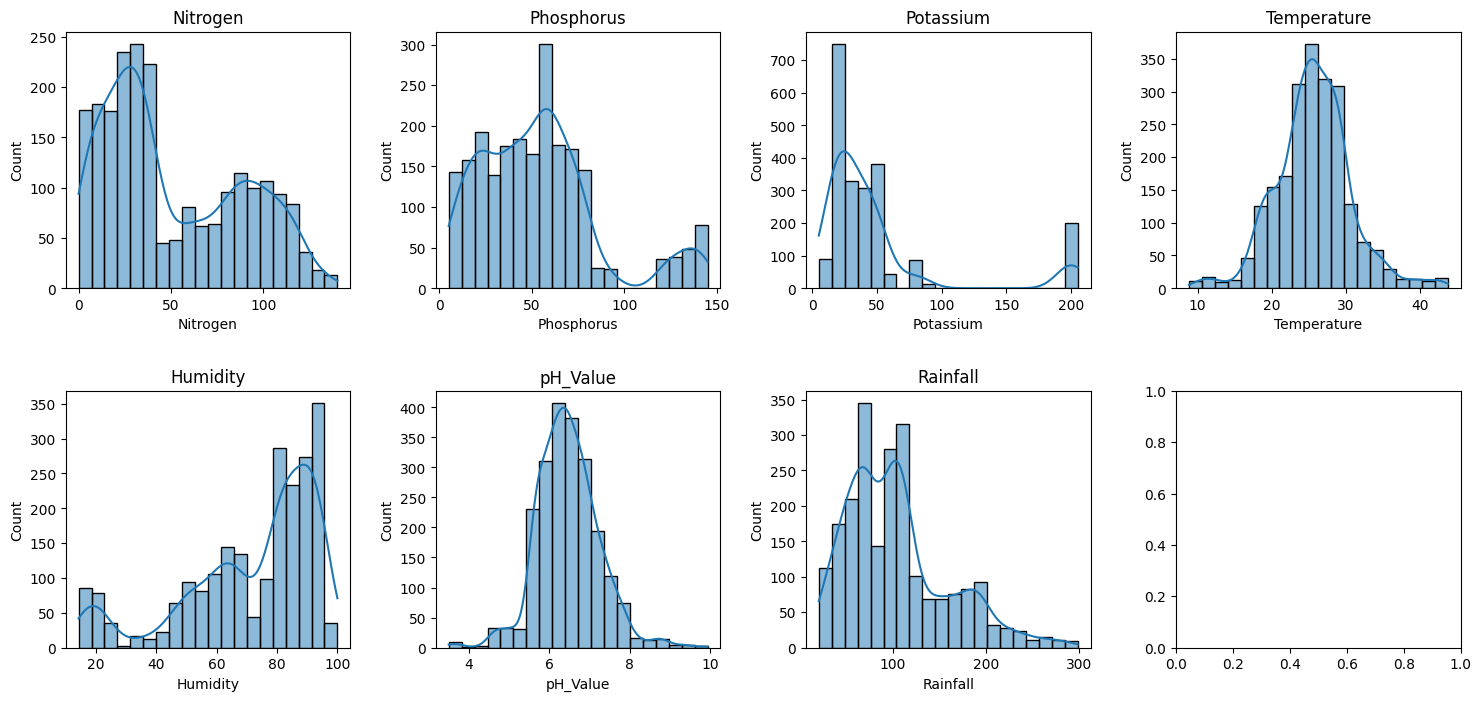

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18,8))

# Plot KDE plots for each column
for i, ax in enumerate(axes.ravel()):
    if i!=7:
        sns.histplot(X.iloc[:,i], kde=True, ax=ax, bins=20)
        ax.set_title(f'{X.columns[i]}', fontsize=12)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()


In [82]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

label_encoder = LabelEncoder()
Y_enco = label_encoder.fit_transform(Y.values.ravel())

X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_enco, 
                                                    test_size=0.2, 
                                                    stratify=Y_enco, 
                                                    random_state=10)

In [83]:
pickle.dump( scaler, open("scaler.pkl", "wb") )

In [84]:
scaler2 = pickle.load(open("scaler.pkl", "rb"))

# Logistic Regression

In [85]:
score1 = []
C = np.linspace(0.2,2,20)

for i,c in enumerate(C):
    lr = LogisticRegression(random_state=20,  max_iter=1000, penalty='l1', C=c, solver='saga')
    lr.fit(X_train, Y_train)
    lr_pred = lr.predict(X_test)
    score1.append(fbeta_score(Y_test,lr_pred, beta=1, average='micro'))

score2 = []
for i,c in enumerate(C):
    lr = LogisticRegression(random_state=20,  max_iter=1000, penalty='l2', C=c, solver='saga')
    lr.fit(X_train, Y_train)
    lr_pred = lr.predict(X_test)
    score2.append(fbeta_score(Y_test, lr_pred, beta=1, average='micro'))

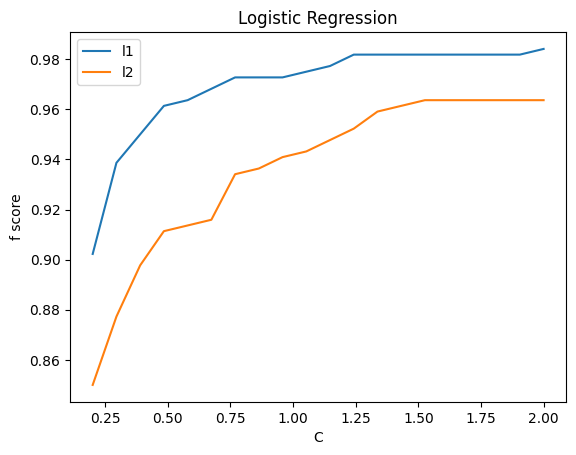

In [86]:
plt.plot(C, score1, label="l1")
plt.plot(C, score2, label="l2")
plt.xlabel("C")
plt.ylabel("f score")
plt.title("Logistic Regression")
plt.legend()
plt.show()

In [87]:
f1_lr = max(score1)
f1_lr

np.float64(0.9840909090909091)

In [88]:
model_lr = LogisticRegression(random_state=20, 
                              max_iter=1000, 
                              solver='saga', 
                              C=1.5,
                              penalty='l1')
model_lr.fit(X_train, Y_train)

LogisticRegression(C=1.5, max_iter=1000, penalty='l1', random_state=20,
                   solver='saga')

In [89]:
filename = 'model_lr.pkl'
pickle.dump(model_lr, open(filename, 'wb'))

# KNN

In [90]:
max_k = 50
f1_scores = []
accuracy = []

In [91]:
for i in range(1,max_k):
    knn = KNeighborsClassifier( n_neighbors=i )
    knn.fit(X_train, Y_train)
    pred = knn.predict(X_test)

    f1_scores.append( fbeta_score(Y_test, pred, beta=1, average='micro') )
    accuracy.append( accuracy_score(Y_test, pred) )
    

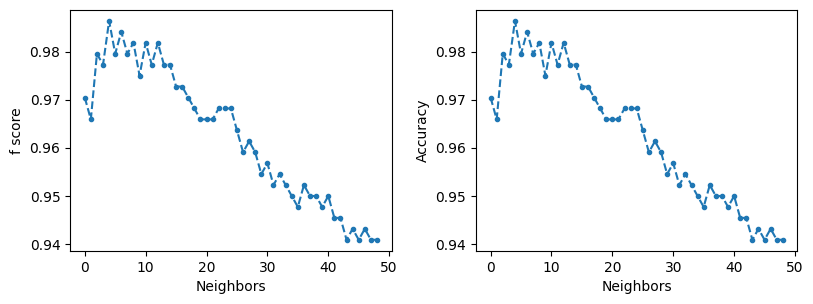

In [92]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8,3))
fig.tight_layout(w_pad=3)

axs[0].plot(f1_scores, "--.")
axs[0].set_ylabel("f score")
axs[0].set_xlabel('Neighbors')

axs[1].plot(accuracy, "--.")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel('Neighbors')

plt.show()

In [93]:
f1_knn = max(f1_scores)
f1_knn

np.float64(0.9863636363636363)

In [94]:
model_knn = KNeighborsClassifier( n_neighbors=5 )
model_knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [95]:
pickle.dump( model_knn, open("model_knn.pkl", "wb"))

# SVM

In [96]:
par_grid = {
    'C': [1,5,10,15,20,25,30],
    'kernel' : ['poly', 'rbf', 'sigmoid']
}

In [97]:
model = SVC()

In [98]:
grid_search = GridSearchCV(estimator = model, 
                           param_grid = par_grid, 
                           cv = 5, 
                           scoring ='f1_micro',
                           verbose = 1)

In [99]:
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

Fitting 5 folds for each of 21 candidates, totalling 105 fits


In [100]:
best_params

{'C': 20, 'kernel': 'rbf'}

In [101]:
grid_search.best_score_

np.float64(0.9892045454545455)

In [102]:
model_SVC = SVC( C=20, kernel='rbf' , probability=True)
model_SVC.fit( X_train, Y_train )

SVC(C=20, probability=True)

In [103]:
pickle.dump( model_SVC, open("model_SVC.pkl", "wb") )

# Desicion Tree

In [104]:
params_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 5]
}
model = DecisionTreeClassifier(random_state=20)

In [105]:
grid_search = GridSearchCV(estimator = model, 
                        param_grid = params_grid, 
                        scoring='f1_micro',
                        cv = 5, 
                        verbose = 1)
grid_search.fit(X_train, Y_train)
best_params = grid_search.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [106]:
f1_tree = grid_search.best_score_
f1_tree

np.float64(0.9852272727272726)

In [107]:
best_params

{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1}

In [108]:
model_tree = DecisionTreeClassifier( criterion='gini', max_depth=15, min_samples_leaf=1, random_state=20 )
model_tree. fit( X_train, Y_train )

DecisionTreeClassifier(max_depth=15, random_state=20)

In [109]:
pickle.dump( model_tree, open("model_tree.pkl", "wb"))

# Ensemble models

### Bagging

In [110]:
param_grid = {
    'n_estimators': [2*n+1 for n in range(10)],
    'estimator__max_depth' : [2*n+1 for n in range(10) ] }

Bag = BaggingClassifier(estimator = DecisionTreeClassifier(), 
                        random_state=20, 
                        bootstrap=True)

In [111]:
param_grid

{'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'estimator__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}

In [112]:
search = GridSearchCV(estimator=Bag, 
                      param_grid=param_grid, 
                      scoring='f1_micro', 
                      cv=3)

In [113]:
search.fit(X_train, Y_train)

GridSearchCV(cv=3,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=20),
             param_grid={'estimator__max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17,
                                                  19],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             scoring='f1_micro')

In [114]:
f1_baggin = search.best_score_
f1_baggin

np.float64(0.9920451263922724)

In [115]:
search.best_params_

{'estimator__max_depth': 13, 'n_estimators': 13}

In [116]:
model_bagging = BaggingClassifier(estimator=DecisionTreeClassifier( max_depth=13 ),
                                  n_estimators=13, 
                                  random_state=20,
                                  bootstrap=True)
model_bagging.fit( X_train, Y_train )

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=13),
                  n_estimators=13, random_state=20)

In [117]:
pickle.dump( model_bagging, open("model_bagging_DT.pkl", "wb") )

### Random Forest

In [118]:
model = RandomForestClassifier(random_state=20)

In [119]:
param_grid = {'n_estimators': [2*n+1 for n in range(14)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["sqrt", "log2"]}

In [120]:
param_grid

{'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27],
 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
 'max_features': ['sqrt', 'log2']}

In [121]:
search = GridSearchCV(estimator=model, 
                      param_grid=param_grid,
                      scoring='f1_micro')

search.fit(X_train, Y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=20),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27]},
             scoring='f1_micro')

In [122]:
search.best_score_

np.float64(0.9943181818181819)

In [123]:
search.best_params_

{'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 27}

In [124]:
model_rf = RandomForestClassifier(max_depth=11,
                                  max_features='sqrt',
                                  n_estimators=27)
model_rf.fit( X_train, Y_train )

RandomForestClassifier(max_depth=11, n_estimators=27)

In [125]:
pickle.dump( model_rf, open("model_rf.pkl", "wb") )

### Stacking

In [126]:
Y_train

array([14,  1, 16, ...,  1, 10, 18])

In [127]:
#estimators = [('SVM',SVC(random_state=42, max_iter=100)),('KNN',KNeighborsClassifier()),('dt',DecisionTreeClassifier())]
estimators = [('KNN',KNeighborsClassifier()),('dt',DecisionTreeClassifier())]

In [128]:
clf = StackingClassifier( estimators=estimators, 
                         final_estimator= LogisticRegression())
#clf.fit(X_train, Y_train)
#clf


param_grid = {
    'dt__max_depth': [n for n in range(1,10)], # dont use 0
    'dt__random_state':[20],
    #'SVM__C':[0.01,0.1,1],
    #'SVM__kernel':['linear', 'poly', 'rbf'],
    'KNN__n_neighbors':[1,4,8,9] 
    }

In [129]:
search = GridSearchCV(estimator=clf, 
                      scoring='f1_micro',
                      cv=5,
                      param_grid=param_grid)
search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=StackingClassifier(estimators=[('KNN',
                                                       KNeighborsClassifier()),
                                                      ('dt',
                                                       DecisionTreeClassifier())],
                                          final_estimator=LogisticRegression()),
             param_grid={'KNN__n_neighbors': [1, 4, 8, 9],
                         'dt__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'dt__random_state': [20]},
             scoring='f1_micro')

In [130]:
search.best_score_

np.float64(0.9909090909090909)

In [131]:
search.best_params_

{'KNN__n_neighbors': 8, 'dt__max_depth': 9, 'dt__random_state': 20}

In [132]:
model_st = clf = StackingClassifier(estimators=[("rf", DecisionTreeClassifier(random_state=20, max_depth=9)),
                                                ("knn",KNeighborsClassifier(n_neighbors=8))], 
                                    final_estimator= LogisticRegression())

In [133]:
pickle.dump(model_st, open("model_st.pkl", "wb"))

### AdaBoost

In [134]:
ABC = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                         algorithm='SAMME')

param_grid = {'n_estimators': [10, 50, 100, 150, 200],
              'learning_rate': [0.1, 0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid,
                      scoring='f1_micro',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, Y_train)

In [135]:
GV_ABC.best_score_

np.float64(0.2727272727272727)

In [136]:
GV_ABC.best_params_

{'learning_rate': 0.1, 'n_estimators': 100}

In [137]:
model_AB_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                              n_estimators=100,
                              learning_rate=0.1,
                              algorithm='SAMME')
model_AB_boost.fit(X_train, Y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.1, n_estimators=100)

In [138]:
pickle.dump(model_AB_boost, open("model_AB_boost.pkl", "wb"))

# Test the models 

In [139]:
classes = ['Apple','Banana', 'Blackgram', 'ChickPea', 'Coconut', 'Coffee', 'Cotton', 'Grapes',
           'Jute', 'KidneyBeans', 'Lentil', 'Maize', 'Mango', 'MothBeans', 'MungBean', 'Muskmelon',
           'Orange', 'Papaya', 'PigeonPeas', 'Pomegranate', 'Rice', 'Watermelon']

In [140]:
models = ["model_lr.pkl","model_knn.pkl","model_SVC.pkl",
          "model_tree.pkl", "model_rf.pkl","model_AB_boost.pkl",
          "model_bagging_DT.pkl"]

In [141]:
model_files = {
    "model_lr.pkl": "Logistic Regression",
    "model_knn.pkl": "KNN",
    "model_SVC.pkl": "Support Vector",
    "model_tree.pkl": "Desicion Tree",
    "model_rf.pkl": "Random Forest",
    "model_AB_boost.pkl": "AdaBoost",
    "model_bagging_DT.pkl":"Bagging" 
}

model_lr.pkl
model_knn.pkl
model_SVC.pkl
model_tree.pkl
model_rf.pkl
model_AB_boost.pkl
model_bagging_DT.pkl


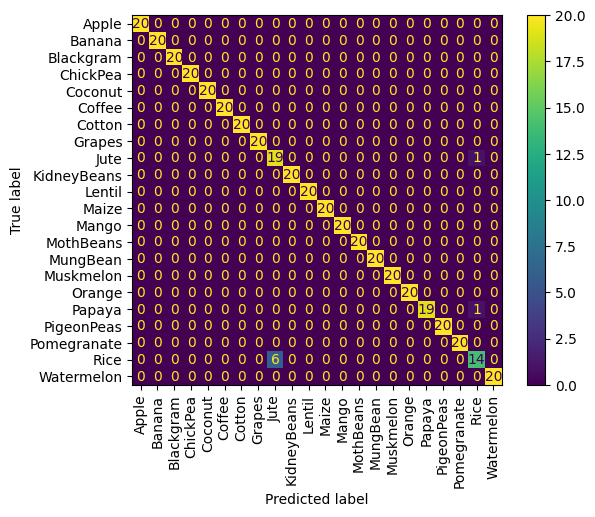

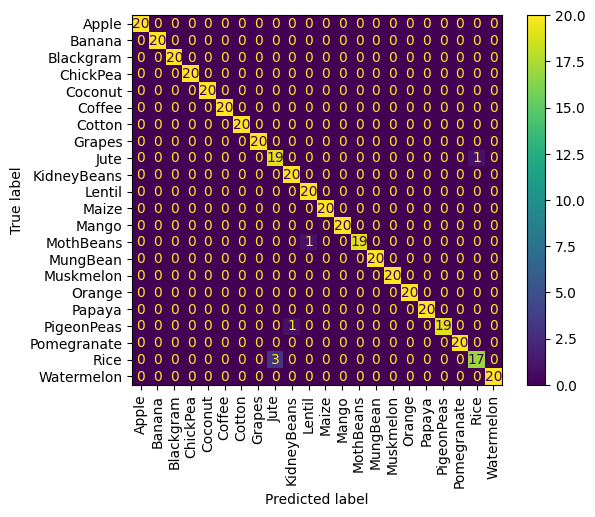

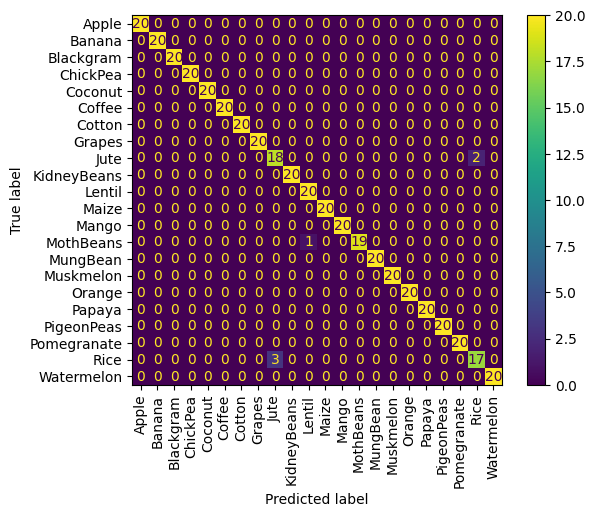

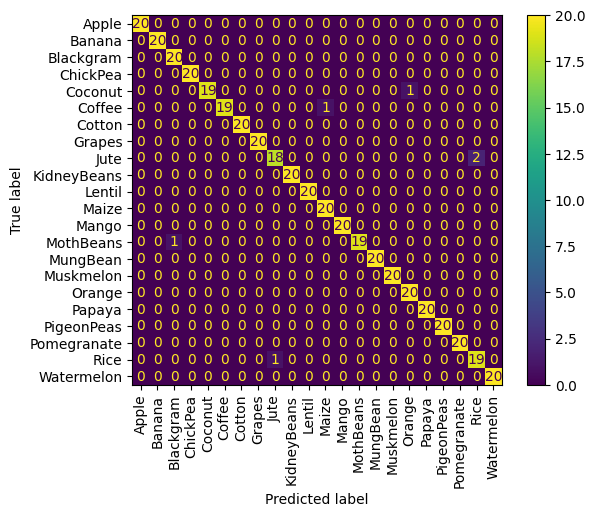

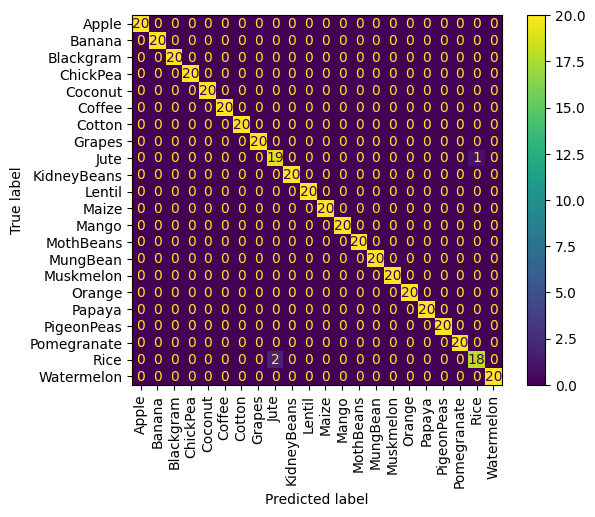

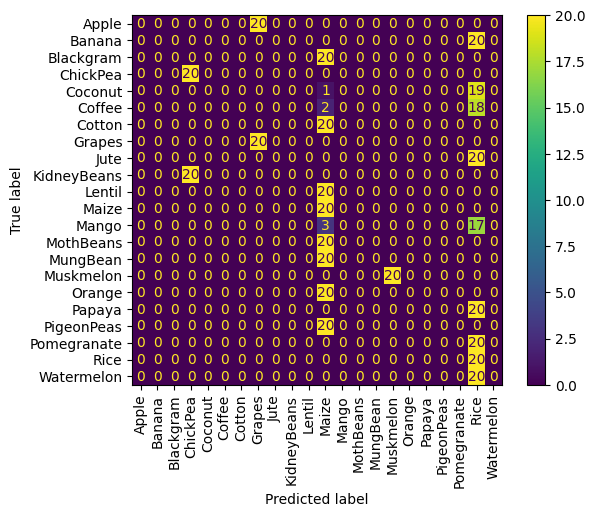

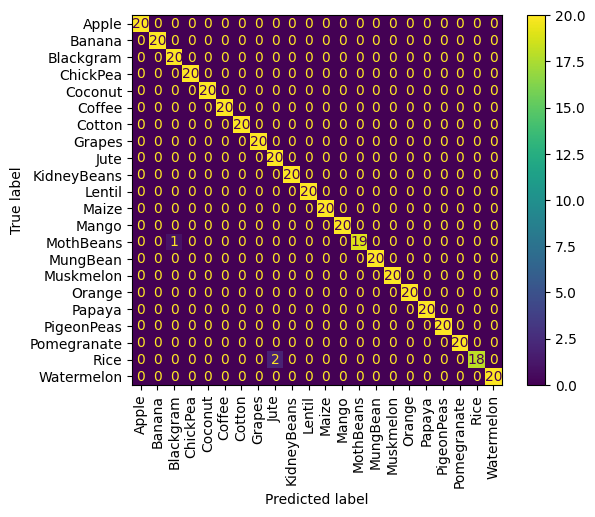

In [209]:
#loaded_scaler = pickle.load(open("scaler.pkl", "rb"))
f_scores = []
accuracies = []
matrix = []
for model in models:
    loaded_model = pickle.load(open(model,"rb"))
    
    # fbeta_score, accuracy_score
    accuracies.append(round(accuracy_score( y_true=Y_test,y_pred=loaded_model.predict(X_test) ), 3))
    f_scores.append(fbeta_score(y_true=Y_test,y_pred=loaded_model.predict(X_test), 
                                beta=1, average='micro').round(3))
    matrix.append(confusion_matrix(y_true=Y_test, y_pred=loaded_model.predict(X_test)))

    # Confusion matrix images
    dist = ConfusionMatrixDisplay.from_estimator(estimator=loaded_model, 
                                                 X=X_test, y=Y_test,
                                                 display_labels=classes,
                                                 xticks_rotation="vertical")
    plt.savefig(os.path.join('images',model.split(".")[0] +'.png'), bbox_inches="tight")

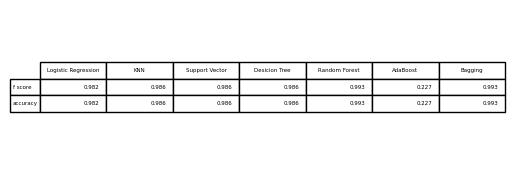

In [143]:
metrics = pd.DataFrame(data=[f_scores, accuracies], index=["f score", "accuracy"], columns=model_files.values())
fig, ax = plt.subplots(figsize=(6, 2))  # Set the figure size
ax.axis('off')  # Turn off the axis

# Create the table and add it to the plot
pd.plotting.table(ax, metrics, loc='center')

# Save the figure as an image
plt.savefig('dataframe_image.png', bbox_inches='tight', dpi=300)

## Feature Importance

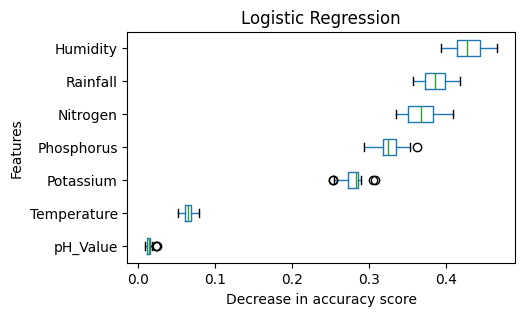

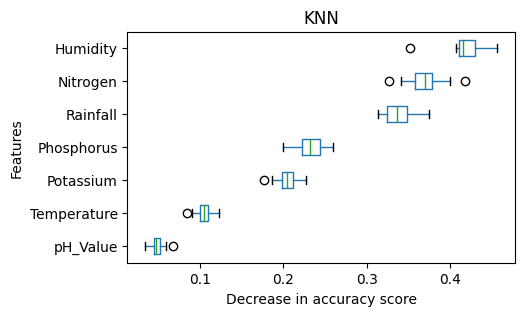

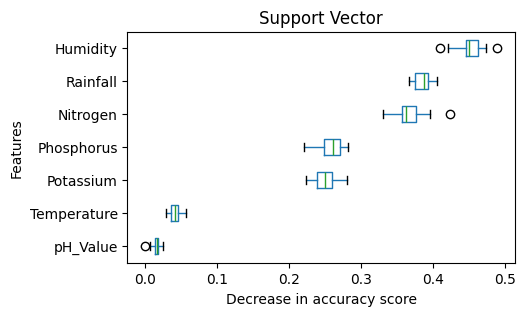

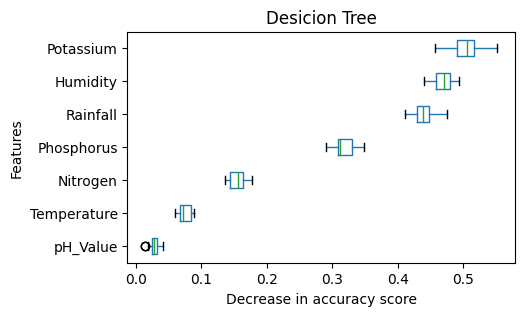

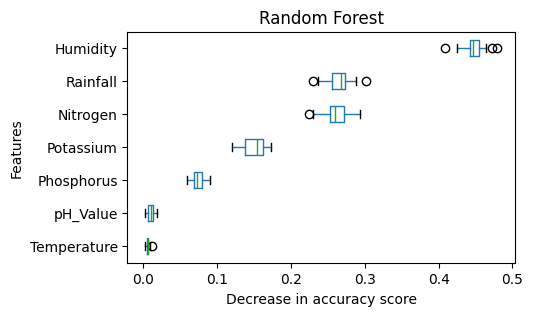

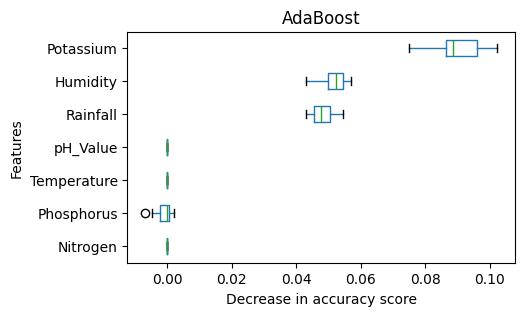

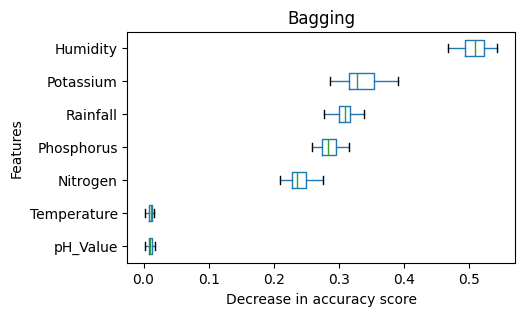

In [214]:
for model in models:
    loaded_model = pickle.load(open(model,"rb"))
    feature_importances = permutation_importance(estimator=loaded_model,
                                                X = X_test, y = Y_test, 
                                                n_repeats=20,random_state=123, n_jobs=2)

    # features importance data frame
    feature_plot = {}
    for per, feat in zip(feature_importances.importances, data.columns[:-1]):
        feature_plot[feat] = per
    feature_plot_df = pd.DataFrame(feature_plot)

    # sorting values
    medians = feature_plot_df.median()
    sorted_features = medians.sort_values(ascending=True).index
    feature_plot_df_sorted = feature_plot_df[sorted_features]

    # Plotting
    plt.figure(figsize=(5, 3))
    feature_plot_df_sorted.boxplot(grid=False, vert=False)

    # Adding title and labels
    plt.title(model_files[model])
    plt.ylabel('Features')
    plt.xlabel('Decrease in accuracy score')
    plt.savefig(os.path.join("images","fi_"+model.split(".")[0]+".png"), bbox_inches="tight")